# Авиахакатон2022. Cezar

### Authors: Konstantin K., Nikita P., Michael Y, Tynarbek B, Iliya S.

### Работа состояла из нескольких этапов
- Изучение полученных данных, выявление взаимосвязей в разрозненных данных.
- Структурирвание исходных данных и создание взаимосвязей, как основы будущей модели.
- Проектирование модели данных на основе `.xslx` файлов, использование библиотеки `pandas`.
- Выявление отклонений между фактическим объмом и зарезервированным:
$$
\Delta_{\%}=\dfrac{V_{fact}-V_{res}}{V_{fact}}\cdot 100\%.
$$
- Создание визуализации для сравнительного анализа.
- Прогнозирование данных на `3` и `6` месяцев

Имортирование библиотек

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

#### 1) Структурирвоание данных по хранению и резервированию объемов `прихода`, `расхода` и `хранения`.

Файлы используемые для работы:
- `6.Приходные операции_2020-2021.xlsx = inop_20_21` - данные по увеличению объёма
- `5.Расходные операции_янв-дек2021.xlsx = outop_20_21` - данные по уменьшению объёма.
- `4.Ожидаемые поставки_Январь2021.xlsx = wship_2021` - оф.прогноз по увеличению объёма.
- `1.ОСНОВНОЙ Факт объемы_м3_2017_2022_по дням1.xlsx = fact_2021` - факт объёма.

Загрузка данных

In [4]:
inop_20_21 = pd.read_excel(r".\Data\6.Приходные операции_2020-2021.xlsx")

In [20]:
outop_20_21 = pd.read_excel(r".\Data\5.Расходные операции_янв-дек2021.xlsx")

In [8]:
wship_2021 = pd.read_excel(r".\Data\4.Ожидаемые поставки_Январь2021.xlsx")

In [10]:
fact_2021 = pd.read_excel(r".\Data\1.ОСНОВНОЙ Факт объемы_м3_2017_2022_по дням1.xlsx", sheet_name="2021")

Обработка `outop_20_21`

In [21]:
outop_20_21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192414 entries, 0 to 192413
Data columns (total 13 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Дата операции                   192414 non-null  datetime64[ns]
 1   Тип операции                    192414 non-null  object        
 2   Источник операции               192414 non-null  object        
 3   Код позиции                     192414 non-null  object        
 4   Описание позиции                192414 non-null  object        
 5   Код организации источника       192414 non-null  object        
 6   Описание организации источника  192414 non-null  object        
 7   № Площадки                      191427 non-null  object        
 8   Количество операции             192414 non-null  float64       
 9   ЕИ                              192414 non-null  object        
 10  Объем за единицу                192315 non-null  float64

Индексирование по датам `"Дата операции"`

In [24]:
outop_20_21.set_index("Дата операции")

,Дата операции,Тип операции,Источник операции,Код позиции,Описание позиции,Код организации источника,Описание организации источника,№ Площадки,Количество операции,ЕИ,Объем за единицу,Общий объем,ЕИ объема
0,2021-03-26,Списание в монтаж,Зак. на перемещ.,132.019.000078,Ответвитель направленный EG 10дБ 376..1000МГц ...,304,"Склад ответхранения, СТА Карго, Северо-Запад",PL_78_21271 (300),-6.0,шт,0.000375,0.00225,кбм
1,2021-04-20,Списание в монтаж,Зак. на перемещ.,132.019.000080,Ответвитель направленный EG 15дБ 376..1000МГц ...,304,"Склад ответхранения, СТА Карго, Северо-Запад",PL_78_04315 (300),-3.0,шт,0.035700,0.10710,кбм


Замена `<space>` на `_` в названии колонок

In [31]:
outop_20_21.columns = [x.replace(' ', '_') for x in outop_20_21.columns]

In [45]:
outop_20_21.columns

Index(['Тип_операции', 'Источник_операции', 'Код_позиции', 'Описание_позиции',
       'Код_организации_источника', 'Описание_организации_источника',
       '№_Площадки', 'Количество_операции', 'ЕИ', 'Объем_за_единицу',
       'Общий_объем', 'ЕИ_объема'],
      dtype='object')

Выборка нужных колонок

In [52]:
outop_masked = outop_20_21[['Код_организации_источника', 'Общий_объем']]
outop_masked.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 192414 entries, 2021-03-26 to 2020-12-22
Data columns (total 2 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Код_организации_источника  192414 non-null  object 
 1   Общий_объем                192315 non-null  float64
dtypes: float64(1), object(1)
memory usage: 4.4+ MB


Краткая статистика выбранных данных

In [57]:
outop_masked.describe(include='all')

,Код_организации_источника,Общий_объем
count,192414,192315.000000
unique,7,NaN
top,304,NaN
freq,76618,NaN
mean,NaN,0.148468
std,NaN,1.086015
min,NaN,0.000000
25%,NaN,0.002340
50%,NaN,0.014329
75%,NaN,0.075264


Количество уникальных регионов - `'Код_организации_источника'`

In [59]:
outop_masked["Код_организации_источника"].nunique()

7

In [64]:
outop_101 = outop_masked[
    outop_masked.Код_организации_источника.str.contains("101", regex=True)
]

In [66]:
outop_101.head(8)

,Код_организации_источника,Общий_объем
Дата операции,,
2021-04-07,101,0.00625
2021-03-02,101,0.04080
2021-04-07,101,0.08160
2021-04-28,101,0.04080
2021-06-11,101,0.04080
2021-05-27,101,0.00012
2021-02-01,101,0.00456
2021-02-05,101,0.00456


Работа с `inop_20_21`

In [96]:
inop_20_21.head(2)

,Дата_операции,Тип_операции_по_приходным_операциям,Код_позиции,Описание_позиции,Код_Организации,Описание_Организации,ЕИ,Количество_,Объем_за_единицу,Общий_объем,ЕИ_объема
0,2020-01-09,Поступление ЗП,145.346.000338,Антенна MOBI MB3F2600-65-1717.5DDE-DFM-IN,К04,"Склад ответхранения, Мэйджор, КЦ",шт,48.0,0.181116,8.693568,кбм
1,2020-01-09,Поступление ЗП,145.346.000338,Антенна MOBI MB3F2600-65-1717.5DDE-DFM-IN,К04,"Склад ответхранения, Мэйджор, КЦ",шт,11.0,0.181116,1.992276,кбм


In [92]:
inop_20_21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103113 entries, 0 to 103112
Data columns (total 11 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   Дата операции                        103113 non-null  datetime64[ns]
 1   Тип операции по приходным операциям  103113 non-null  object        
 2   Код позиции                          103113 non-null  object        
 3   Описание позиции                     103113 non-null  object        
 4   Код Организации                      103113 non-null  object        
 5   Описание Организации                 103113 non-null  object        
 6   ЕИ                                   103113 non-null  object        
 7   Количество                           103113 non-null  float64       
 8   Объем за единицу                     102902 non-null  float64       
 9   Общий объем                          102902 non-null  float64       
 

Проведение операций аналогичных `outop_20_21`

In [ ]:
inop_20_21.set_index("Дата операции")

In [ ]:
inop_20_21.columns = [x.replace(' ', '_') for x in inop_20_21.columns]

In [102]:
inop_20_21.columns

Index(['Дата_операции', 'Тип_операции_по_приходным_операциям', 'Код_позиции',
       'Описание_позиции', 'Код_Организации', 'Описание_Организации', 'ЕИ',
       'Количество_', 'Объем_за_единицу', 'Общий_объем', 'ЕИ_объема'],
      dtype='object')

Приведение названий к единому виду

In [105]:
inop_20_21.rename(
    columns={
        'Код_Организации': 'Код_организации_источника',
        'Количество_': 'Количество'
    },
    inplace=True
)
inop_20_21.columns

Index(['Дата_операции', 'Тип_операции_по_приходным_операциям', 'Код_позиции',
       'Описание_позиции', 'Код_организации_источника', 'Описание_Организации',
       'ЕИ', 'Количество', 'Объем_за_единицу', 'Общий_объем', 'ЕИ_объема'],
      dtype='object')

In [107]:
inop_masked = inop_20_21[['Код_организации_источника', 'Общий_объем']]

In [115]:
inop_masked.describe(include="all")

,Код_организации_источника,Общий_объем
count,103113,102902.000000
unique,6,NaN
top,304,NaN
freq,52181,NaN
mean,NaN,1.877905
std,NaN,374.322000
min,NaN,0.000000
25%,NaN,0.006650
50%,NaN,0.035100
75%,NaN,0.168264


Обращаем внимание на квантили

In [116]:
inop_masked['Общий_объем'].quantile([0.01, 0.05, 0.95, 0.99])

0.01     0.000000
0.05     0.000240
0.95     2.250000
0.99    13.247978
Name: Общий_объем, dtype: float64

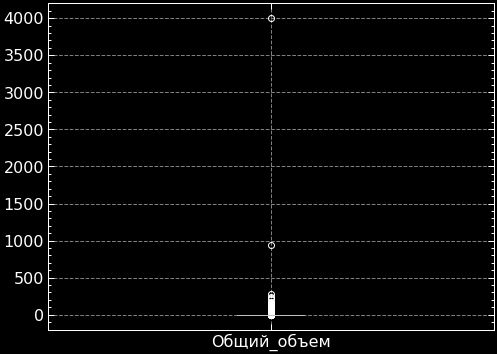

In [146]:
inop_masked.plot.box(figsize=(8,6))
plt.show()

В данной выборке данных присутствует неравноценный максимум.

In [133]:
inop_masked.loc[inop_masked["Общий_объем"] == inop_masked["Общий_объем"].max()]

,Код_организации_источника,Общий_объем
48222,702,4000.0


Удалим его первые 3 максимума

In [139]:
inop_masked["Общий_объем"].nlargest(3)

48222    4000.00
49586     939.25
24252     274.89
Name: Общий_объем, dtype: float64

In [ ]:
inop_masked = inop_masked.drop(inop_masked["Общий_объем"].nlargest(3))

In [130]:
inop_masked['Общий_объем'].quantile([0.01, 0.05, 0.95, 0.99])

0.01     0.000000
0.05     0.000240
0.95     2.250000
0.99    13.245839
Name: Общий_объем, dtype: float64

#### 2) Визуализация данных при помощи `matplotlib`.

In [147]:
plt.style.use(["grid", 'science', 'notebook'])

In [153]:
inop_101 = inop_masked[
    inop_masked.Код_организации_источника.str.contains("101", regex=True)
]

In [154]:
inop_101

,Код_организации_источника,Общий_объем
8,101,0.723677
9,101,2.914560
10,101,0.013720
18,101,0.315900
19,101,0.421200
...,...,...
27517,101,0.523250
28053,101,0.081396
28058,101,0.136401
28153,101,0.058800


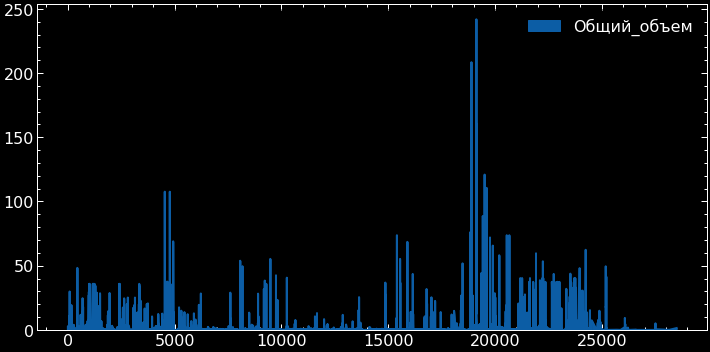

In [156]:
inop_101.plot.area(figsize=(12,6))
plt.show()

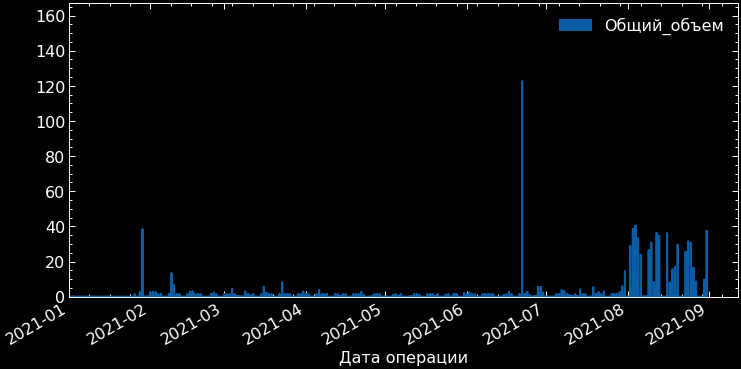

In [160]:
outop_101.plot.area(figsize=(12,6))
plt.xlim(("2021-01-01", "2021-09-12"))
plt.show()

Экспорт данных в `.csv` для прогнозирования

In [184]:
outop_101["Общий_объем"].to_csv("outop_101_vol.csv")

In [168]:
inop_101["Общий_объем"].to_csv("inop_101_vol.csv")

#### 2) Прогнозирование организованных данных.

#### Аппроксимация линейной и квадратичной функцией методом наименьших квадратов

In [161]:
import numpy as np
import math as mt
import seaborn as sb
import scipy.stats as sps
import statistics as st
import random
import os
import time


%matplotlib inline

In [162]:
class prognoz:
    '''
    В основном классе есть функции подсчета: 

        sum_x() - сумма предикторов х
        sum_y() - сумма значений y
        square_x() - сумма квадратов предикторов x
        sum_xy() - сумма произведений предикторов x и y
        var_a() - значение a в линейной функции
        var_b() - значение b в линейной функции
        var_abc() - коэффициенты квадратичной функции (a,b,c соответственно)    
        approx_func() - поиск отклонений, где функция стремится к минимуму для линейной функции 
        function_str()[0] - строковое выражение функции линейной
        function_str()[1] - строковое выражение функции квадратичной
        array_square_f() - аппроксимированные значения для квадратичной функции
        array_f() - аппроксимированные значения для линейной функции
        sum_3_degree - сумма предикторов x в 3 степени
        sum_4_degree - сумма предикторов x в 4 степени
        sum_x2_y - сумма предикторов x^2 и y 
        main_matrix - система уравнений
        sigma - стандартное отклонение массива f
        dispersion - дисперсия массива f

    Функции визуализации:
        prog.draw_board() - визуализация линейной функции
        prog.draw_board_f2() - визуализация квадратичной функции
        В функциях для прогнозирования:
            draw_predict(self, pred_x) 
            draw_predict_square(self, pred_x)

    ACHTUNG! В эти функции передается список - pred_x со значениями прогнозных точек x. 
    Желательный ввод для обеих функций - список с равномерным шагом. Для линейного прогнозирования
    можно ввести значение в формате списка. Но для квадратичной диапазон до прогнозируемого значения x
    с равномерным шагом.
    '''
    value = 0 

    def __init__(self, csv_file, array_x = [], array_y=[]):
        self.csv_file = pd.read_csv(csv_file, sep=';')
        #self.array_x = self.csv_file['X'].tolist()
        try:
            self.array_x = [float(i.replace(',','.')) for i in self.csv_file['X'].tolist()]
        except AttributeError:
            self.array_x = self.csv_file['X'].tolist()
        try:
            self.array_y = [float(i.replace(',','.')) for i in self.csv_file['Y'].tolist()]
        except AttributeError:
            self.array_y = self.csv_file['Y'].tolist()
    
    def sum_x(self):
        return(sum(self.array_x))
        
    def sum_y(self):
        return(sum(self.array_y[i] for i in range(len(self.array_y))))

    def square_x(self):
        return(sum(self.array_x[i]**2 for i in range(len(self.array_x))))
        
    def sum_xy(self):
        return(sum([self.array_x[i] * self.array_y[i] for i in range(len(self.array_x))]))
    
    def var_a(self):
        return((len(self.array_x)*prognoz.sum_xy(self) - prognoz.sum_x(self) * prognoz.sum_y(self))/
        (len(self.array_x)*prognoz.square_x(self) - (prognoz.sum_x(self)**2)))
    
    def var_b(self):
        return((prognoz.sum_y(self)-prognoz.var_a(self)*prognoz.sum_x(self)) / (len(self.array_x)))
    
    def approx_func(self):
        a = [prognoz.array_f(self)[i] - (prognoz.var_a(self)*self.array_x[i]+ prognoz.var_b(self)) 
                                         for i in range(len(prognoz.array_f(self)))]
        return([a[i]**2 for i in range(len(a))]) 
     
        '''тут начинается расчет квадратичной функции
        она отличается только тем что добавляются 3 и 4 степени массива x.
            '''
        
    def sum_3_degree(self):
        return(sum(self.array_x[i]**3 for i in range(len(self.array_x))))

    def sum_4_degree(self):
        return(sum(self.array_x[i]**4 for i in range(len(self.array_x))))

    def sum_x2_y(self):
        return(sum([(self.array_x[i]**2)*self.array_y[i] for i in range(len(self.array_x))]))


    def main_matrix(self):
        '''
        система уравнений имеет вид
            ax^4+bx^3+сx^2
            ax^3+bx^2+cx
            ax^2+bx+cn, 
            где n - длина массива
        '''
        return([
                [prognoz.sum_4_degree(self), prognoz.sum_3_degree(self),prognoz.square_x(self)],
                [prognoz.sum_3_degree(self), prognoz.square_x(self), prognoz.sum_x(self)],
                [prognoz.square_x(self), prognoz.sum_x(self), len(self.array_x)]
                ])

    def var_abc(self):
        a = np.array(prognoz.main_matrix(self))
        b = np.array([prognoz.sum_x2_y(self), prognoz.sum_xy(self), prognoz.sum_y(self)])
        return(np.linalg.inv(a).dot(b))

    def array_f(self):
        return([prognoz.var_a(self)*self.array_x[i] + prognoz.var_b(self) 
                for i in range(len(self.array_x))])
        
    def array_square_f(self):
        return([prognoz.var_abc(self)[0]*(self.array_x[i]**2)+
                (prognoz.var_abc(self)[1]*self.array_x[i])+
                prognoz.var_abc(self)[2] for i in range(len(self.array_x))])

    def sigma(self):
        c = [prognoz.var_a(self)*self.array_x[i] + prognoz.var_b(self) for i in range(len(self.array_x))]
        return(mt.sqrt(sum([(i-j)**2 for i,j  in zip(self.array_y, c)])/len(self.array_y)))

    def dispersion(self):
        avg = sum(self.array_y) / len(self.array_y)
        var = sum((x-avg)**2 for x in self.array_y) / len(self.array_y)
        return(var)
    def otklon_funct(self):
        c = [prognoz.var_a(self)*self.array_x[i] + prognoz.var_b(self) for i in range(len(self.array_x))]
        q = sum([(i-j)**2 for i,j  in zip(self.array_y, c)])
        return(q)
    def function_str(self):
        '''проблема: при отрицательных значениях + остается'''
        y1 =('Вид линейной аппроксимирующей функции:\n  y = {}x+{}'
            .format(round(prognoz.var_a(self), 2), round(prognoz.var_b(self), 2)))
        y2 =('Вид квадратичной аппроксимирующей функции:\n  y = {}x^2+{}x+{}'
            .format(round(prognoz.var_abc(self)[0], 2), round(prognoz.var_abc(self)[1], 2),round(prognoz.var_abc(self)[2]), 2))
        y3 = [y1,y2]
        return(y3)
    
    def draw_board(self):
        
        x = np.array(self.array_x)
        y = np.array(self.array_y)
        f = np.array(prognoz.array_f(self))
        ci_68 = np.std(y)
        ci_95 = 2 * np.std(y) 
        ci_99 = 3 * np.std(y)
        
        
        fig, axes = plt.subplots(1, 2)
        fig.set_facecolor('floralwhite')
        axes[0].text(x[0],y[0], s =f'{prognoz.function_str(self)[0]}\nДисперсия: {(prognoz.sigma(self))**2}', fontsize=8, bbox={'facecolor':'yellow','alpha':0.8}, horizontalalignment="left")  
        axes[0].plot(x, y, 'b-..', label = 'Заданные точки y', linewidth=0.5, alpha = 0.5)
        axes[0].plot(x, f, 'r' , label='Тренд',  linewidth=2)
        axes[0].legend(loc=2)
        axes[0].set_title('Аппроксимация линейной функции')
        axes[0].set_xlabel("X")
        axes[0].set_ylabel("Y, F")
        axes[0].grid(which="major", axis='both', alpha=.3)
        
        axes[1].plot(x, y, 'b-..', label = 'Заданные точки y', linewidth=0.5, alpha = 0.5)
        axes[1].plot(x, f, 'r' , label='Тренд',  linewidth=2)
        
        axes[1].plot(x, f-ci_68,'g--', label="+- sigma", alpha = 0.5)
        axes[1].plot(x, f+ci_68,'g--', alpha = 0.5)
        
        axes[1].plot(x, f-ci_95, 'y.-', label="+- 2sigma", alpha = 0.5)
        axes[1].plot(x, f+ci_95, 'y.-', alpha = 0.5)

        axes[1].plot(x, f-ci_99, 'c-.', label="+- 3sigma", alpha = 0.5)
        axes[1].plot(x, f+ci_99, 'c-.', alpha = 0.5)
        
        axes[1].text(x[0],y[0], s =f'{prognoz.function_str(self)[0]}\nДисперсия: {(prognoz.sigma(self))**2}', fontsize=8, bbox={'facecolor':'yellow','alpha':0.8}, horizontalalignment="left")  
        axes[1].legend(loc=2)
        axes[1].set_title('Аппроксимация линейной функции с доверительными интервалами')
        axes[1].set_xlabel("X")
        axes[1].set_ylabel("Y, F")
        axes[1].grid(which="major", axis='both', alpha=.3)
        
        plt.rcParams['figure.figsize'] = [30, 10]
        plt.show()
        

        return('')
    
    def draw_board_f2(self):

        x = np.array(self.array_x)
        y = np.array(self.array_y)
        f = np.array(prognoz.array_square_f(self))
        
        fig, axes = plt.subplots(1, 2)
        fig.set_facecolor('floralwhite')
        axes[0].text(x[0],y[0],s=f'{prognoz.function_str(self)[1]}\nДисперсия: {(prognoz.sigma(self))**2}', fontsize=8, bbox={'facecolor':'yellow','alpha':0.8}, horizontalalignment="left")  
        axes[0].plot(x, y, 'b-..', label = 'Заданные точки y', linewidth=0.5, alpha = 0.5)
        axes[0].plot(x, f, 'r' , label='Тренд', linewidth=2)
        axes[0].legend(loc=2)
        axes[0].set_title('Аппроксимация квадратичной функции')
        axes[0].set_xlabel("X")
        axes[0].set_ylabel("Y, F")
        axes[0].grid(axis="y")

        ci_68 = np.std(y)
        ci_95 = 2 * np.std(y) 
        ci_99 = 3 * np.std(y)

        axes[1].plot(x, y, 'b-..', label = 'Заданные точки y', linewidth=0.5, alpha = 0.5)
        axes[1].plot(x, f, 'r' , label='Тренд', linewidth=2)
        
        axes[1].text(x[0],y[0],s=f'{prognoz.function_str(self)[1]}\nДисперсия: {(prognoz.sigma(self))**2}', fontsize=8, bbox={'facecolor':'yellow','alpha':0.8}, horizontalalignment="left")  
        axes[1].fill_between(x, (f-ci_68), (f+ci_68), color='blue', alpha=0.1)
        axes[1].fill_between(x, (f-ci_95), (f+ci_95), color='yellow', alpha=.1)
        axes[1].fill_between(x, (f-ci_99), (f+ci_99), color='blue', alpha=0.1)

        axes[1].legend(loc=2)
        axes[1].set_title('Аппроксимация квадратичной функции с доверительными интервалами')
        axes[1].set_xlabel("X")
        axes[1].set_ylabel("Y, F")
        axes[1].grid(axis="y")
        plt.show()


        
    def draw_predict(self, pred_x):
        start_time = time.time()
        arr_x = np.array(self.array_x)
        predx = np.array(pred_x)
        
        x1 = np.concatenate((arr_x, pred_x), axis = None)
        
        x_f = x1.tolist()
        l = [prognoz.var_a(self)*x_f[i] + prognoz.var_b(self) for i in range(len(x_f))]

        x = np.array(self.array_x)
        y = np.array(self.array_y)
        
        fig, axes = plt.subplots()
        fig.set_facecolor('floralwhite')
        axes.plot(x, y, 'b-..', label = 'Заданные точки y', linewidth=0.5, alpha = 0.5)
        axes.plot(x_f, l)
        
        axes.text(x[0],y[0],s=f'{prog.function_str()[0]}\nДисперсия{(prog.sigma())**2}', fontsize=8, bbox={'facecolor':'yellow','alpha':0.8}, horizontalalignment="left")  
    
        axes.legend(loc=2)
        axes.set_title('Прогнозирование линейной функции')
        axes.set_xlabel("X")
        axes.set_ylabel("Y, F")
        axes.grid(axis="y")
        plt.show()
        
        print("--- %s секунд ---" % (time.time() - start_time))    
        print(x_f, l, len(x_f), len(l))
        
    def draw_predict_square(self, pred_x):
        start_time = time.time()
        arr_x = np.array(self.array_x)
        predx = np.array(pred_x)
    
        
        x1 = np.concatenate((arr_x, pred_x), axis = None)
        
        x_f = x1.tolist()
        l = [prognoz.var_abc(self)[0]*(x_f[i]**2)+
                (prognoz.var_abc(self)[1]*x_f[i])+
                prognoz.var_abc(self)[2] for i in range(len(x_f))]

        x = np.array(self.array_x)
        y = np.array(self.array_y)
        
        fig, axes = plt.subplots()
        fig.set_facecolor('floralwhite')
        axes.plot(x, y, 'b-..', label = 'Заданные точки y', linewidth=0.5, alpha = 0.5)
        axes.plot(x_f, l)
        
        axes.text(x[0],y[0],s=prog.function_str()[1], fontsize=8, bbox={'facecolor':'yellow','alpha':0.8}, horizontalalignment="left")  

        axes.legend(loc=2)
        axes.set_title('Прогнозирование квадратичной функции')
        axes.set_xlabel("X")
        axes.set_ylabel("Y, F")
        axes.grid(axis="y")
        plt.show()
    
    
        print("--- %s секунд ---" % (time.time() - start_time))    
        print(x_f, l, len(x_f), len(l))
        return()

#prog = prognoz('prog.csv')
#prog_cleaned = prognoz(iqr.dir())
#prog.draw_board()
#prog_cleaned.draw_board()
#prog.draw_board_f2()
#prog_cleaned.draw_board_f2()


Передача файлов в класс

In [ ]:
prog = prognoz("inop_101_vol.csv")

ВЫВОД

In [ ]:
print('Апроксимированные значения: ',prog.array_f())
print(prog.function_str()[0])
print(prog.function_str()[1])
print('Значение дисперсии: ',(prog.sigma())**2)
prog_cleaned = prognoz(iqr.dir())
print('\nНеочищенная выборка\n')
prog.draw_board()
print('\nОчищенная выборка\n')
prog_cleaned.draw_board()
print('\nНеочищенная выборка\n')
prog.draw_board_f2()
print('\nОчищенная выборка\n')
prog_cleaned.draw_board_f2()
prog.draw_predict(pred_x = [2040])
prog.draw_predict_square(pred_x = [i for i in range (2020,2040)])
print('Отклонение линейной: ',prog.otklon_funct())
print('Отклонение квадратичной: ',prog_cleaned.otklon_funct())

Очистка от выбросов

In [ ]:
iqr = clean_csv(input('Введите название: '))

Введите название: help.csv


       X    Y
0   1950  0.5
1   1960  1.5
2   1970  3.0
3   1980  4.2
4   1990  3.8
5   1992  4.3
6   1995  4.5
7   2000  4.3
8   2001  5.3
9   2002  5.9
10  2003  5.5
11  2004  4.4
12  2005  4.2
13  2006  4.5
14  2007  4.8
15  2008  4.9
16  2009  4.9
17  2010  4.5
18  2011  4.7
19  2012  4.5
20  2013  4.7
21  2014  4.7
22  2015  4.2
23  2016  4.1
24  2017  4.2
25  2018  4.0
26  2019  4.2
27  2020  3.9
28  2021  4.4
       X    Y
3   1980  4.2
4   1990  3.8
5   1992  4.3
6   1995  4.5
7   2000  4.3
8   2001  5.3
11  2004  4.4
12  2005  4.2
13  2006  4.5
14  2007  4.8
15  2008  4.9
16  2009  4.9
17  2010  4.5
18  2011  4.7
19  2012  4.5
20  2013  4.7
21  2014  4.7
22  2015  4.2
23  2016  4.1
24  2017  4.2
25  2018  4.0
26  2019  4.2
27  2020  3.9
28  2021  4.4
0.9848018847719003
AxesSubplot(0.125,0.125;0.775x0.755)
Файл в режиме работы. Закройте файл и повторите попытку!
1


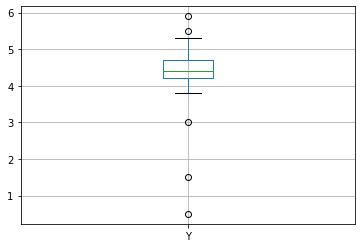

In [ ]:
class clean_csv:
    ''' 
    Класс для очистки от выбросов. Обязательные параметры: название файла.
                                   Необязательные параметры: Процент доступных для исключения точек.
                                                             Максимальное количества итераций
                                                             Название нового, очищенного от выбросов файла
        '''
    def __init__(self, csv, portion = 0.1, max_iter=1000, file_name = 'cleaned_xy.csv'):
        self.csv = csv
        self.portion = portion
        self.max_iter = max_iter
        self.file_name = file_name
        
    def csv_file(self):
        return(pd.read_csv(self.csv, sep =';', decimal = ','))
    
    def boxplot(self):
        csv = clean_csv.csv_file(self)
        boxplot = csv.boxplot(['Y'])
        return(boxplot)
        
    def clean(self):
        csv = clean_csv.csv_file(self)
        for en, x in enumerate(['Y']):
            if en == self.max_iter:
                break
            q_75,q_25 = np.percentile(csv.loc[:,x],[75,25])
            intr_qr = q_75-q_25

            max = q_75+(1.5*intr_qr)
            min = q_25-(1.5*intr_qr)
    
            csv.loc[csv[x] < min,x] = np.nan
            csv.loc[csv[x] > max,x] = np.nan
        csv.isnull().sum()
        csv = csv.dropna(axis = 0)
        return(csv)
    
    def dispersion_difference(self):
        csv = clean_csv.csv_file(self)
        cleaned = clean_csv.clean(self)
        return(csv['Y'].var()-cleaned['Y'].var())
    
    def create_csv(self):
        csv = clean_csv.clean(self)
        try:
            csv.to_csv(self.file_name, sep=';')
        except PermissionError:
            print('Файл в режиме работы. Закройте файл и повторите попытку!')
        return(os.system(self.file_name))
    
    def dir(self):
        return(os.path.abspath(self.file_name))
    
#iqr = clean_csv('prog.csv')#название файла
print(iqr.csv_file()) #датафрейм
print(iqr.clean()) #очищенная выборка
print(iqr.dispersion_difference()) #пункт 3 в) подсчет разницы дисперсий
print(iqr.boxplot()) #ящик с усами
print(iqr.create_csv()) #открывает файлЫ